## Regression

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
chicago_data = gpd.read_file('data/chicago_data.geojson').set_crs("epsg:3857", allow_override=True,)
chicago_data_filter = pd.read_csv('data/chicago_data_filter.csv')

In [3]:
chicago_data_filter = chicago_data_filter.drop(columns = ["GEOID", "alightings"])

In [4]:
chicago_data_filter

,total_pop,median_rent,median_income,median_age,boardings,pct_college_degree,pct_racial_minorities,pct_property_owner,pct_commuter_PuT,DistRes,DistOffice,dist_to_cbd
0,1560.0,800.00000,36250.0,28.7,165.0,0.109321,0.455128,0.372032,0.216612,4920.242486,4925.627689,4254.880809
1,1178.0,796.00000,29643.0,25.4,10.0,0.043406,0.425297,0.223776,0.116402,5032.392357,4704.293453,4386.418475
2,2018.0,1628.00000,159205.0,38.8,160.0,0.630701,0.174430,0.510791,0.457009,1447.692167,3316.507070,13219.823862
3,739.0,1695.00000,238421.0,35.1,255.0,0.690117,0.239513,0.694118,0.538012,933.086191,3034.566761,13636.888713
4,1187.0,1431.00000,181736.0,30.8,92.0,0.550672,0.059815,0.550000,0.467811,649.518623,3038.404730,13744.742055
...,...,...,...,...,...,...,...,...,...,...,...,...
2322,731.0,1145.33871,136382.0,54.0,29.0,0.250847,0.225718,1.000000,0.050132,6706.598460,4990.524149,18634.869923
2323,1022.0,1145.33871,113295.0,46.8,24.0,0.427577,0.423679,0.785523,0.068716,7268.270085,5047.464674,19027.414486
2324,1178.0,769.00000,84766.0,49.9,31.0,0.225989,0.268251,0.856790,0.145313,7807.147727,5113.042707,19441.614566
2325,1200.0,840.00000,39837.0,36.7,26.0,0.153846,0.735833,0.539846,0.308311,5008.658827,4621.365901,20198.227232


In [5]:
# Split the data 60/40
train_set, test_set = train_test_split(chicago_data_filter, test_size = 0.4, random_state = 1)

# create the target variables
y_train = train_set["boardings"].values
y_test = test_set["boardings"].values

# The feature variables
feature_cols = [col for col in chicago_data_filter.columns if col not in ["boardings"]]
X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

### Linear Regression

In [6]:
# linear regression
# create a pipe to scale the data and perform linear regression
linear_pipe = make_pipeline(StandardScaler(), LinearRegression())

# fit the pipeline
print("Linear regression")
linear_pipe.fit(X_train, y_train)

# get the score on training data
training_score = linear_pipe.score(X_train, y_train)
print(f"Training Score = {training_score}")

# get the score on test data
test_score = linear_pipe.score(X_test, y_test)
print(f"Test Score = {test_score}")

Linear regression
Training Score = 0.15041047028390575
Test Score = 0.1341658937539877


### Random Forest

In [7]:
# random forest regression
# create a pipe to scale the data and fit a random forest
forest_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1))

# find the best hyper parameter for the random forest
model_step = "randomforestregressor"
param_grid = {
    f"{model_step}__n_estimators": [5, 10, 15, 20, 30, 50, 100, 200],
    f"{model_step}__max_depth": [2, 5, 7, 9, 13, 21, 33, 51],
}

In [8]:
# Create the grid and use 3-fold CV
grid = GridSearchCV(forest_pipe, param_grid, cv=3)

# Run the search
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=1))]),
             param_grid={'randomforestregressor__max_depth': [2, 5, 7, 9, 13,
                                                              21, 33, 51],
                         'randomforestregressor__n_estimators': [5, 10, 15, 20,
                                                                 30, 50, 100,
                                                                 200]})

In [9]:
# get the best parameters
grid.best_params_

{'randomforestregressor__max_depth': 5,
 'randomforestregressor__n_estimators': 100}

In [10]:
# fit the model based on the hyperparameter selected
forest_pipe = make_pipeline(
    StandardScaler(), RandomForestRegressor(max_depth = 5, n_estimators = 100, random_state=1)
)

# Fit a random forest
print("Random forest")
forest_pipe.fit(X_train, y_train)

# Print the training score
training_score = forest_pipe.score(X_train, y_train)
print(f"Training Score = {training_score}")

# Print the test score
test_score = forest_pipe.score(X_test, y_test)
print(f"Test Score = {test_score}")

Random forest
Training Score = 0.45810097601783506
Test Score = 0.18079286799614014


## Prediction - Chicago Test Set 

In [11]:
# get the prediction from the best random forest model
predictions = grid.best_estimator_.predict(X_test)

In [12]:
# add the prediction result to the testset dataframe
# boardings should be integers
test_set['predictions'] = predictions.round(0)

C:\Users\nj_ta\AppData\Local\Temp/ipykernel_15328/3729048440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions.round(0)


In [13]:
# get the absolute percent err
test_set["APE"] = abs(test_set['predictions'] - test_set['boardings']).round(0)/(test_set['boardings'] + 0.1)

C:\Users\nj_ta\AppData\Local\Temp/ipykernel_15328/3524042313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["APE"] = abs(test_set['predictions'] - test_set['boardings']).round(0)/(test_set['boardings'] + 0.1)


In [14]:
# get the geometry of test set
test_set['geometry'] = chicago_data[chicago_data.index.isin(test_set.index)]['geometry']

C:\Users\nj_ta\AppData\Local\Temp/ipykernel_15328/2790821354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['geometry'] = chicago_data[chicago_data.index.isin(test_set.index)]['geometry']


In [15]:
# set crs to test_set
test_set = gpd.GeoDataFrame(test_set).set_crs('epsg:3857')

In [16]:
test_set

,total_pop,median_rent,median_income,median_age,boardings,pct_college_degree,pct_racial_minorities,pct_property_owner,pct_commuter_PuT,DistRes,DistOffice,dist_to_cbd,predictions,APE,geometry
579,1605.0,1035.00000,81458.0,40.3,55.0,0.271923,0.388785,0.563700,0.166314,3461.758940,5120.755962,17093.309509,56.0,0.018149,"POLYGON ((-9769055.759 5152894.085, -9769001.5..."
1355,2612.0,1239.00000,39738.0,33.6,202.0,0.406909,0.591501,0.354680,0.425296,1754.301683,2126.576765,23367.161000,133.0,0.341415,"POLYGON ((-9761593.123 5160639.415, -9761565.9..."
47,2834.0,1247.00000,71118.0,35.1,2.0,0.128308,0.153846,0.828641,0.116513,10205.629663,4608.894057,26978.858011,21.0,9.047619,"POLYGON ((-9743980.376 5114982.237, -9743980.2..."
1118,1260.0,887.00000,54070.0,40.1,127.0,0.192073,0.226984,0.179577,0.289766,1711.475118,5222.071536,15775.579829,90.0,0.291109,"POLYGON ((-9766193.735 5152584.426, -9766165.4..."
614,940.0,786.00000,40962.0,41.9,72.0,0.302190,0.992553,0.087866,0.253886,1103.893689,2641.064312,11489.851385,94.0,0.305132,"POLYGON ((-9752803.782 5128914.884, -9752802.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,1791.0,845.00000,38750.0,31.6,43.0,0.101029,0.499162,0.431542,0.318966,4668.062270,5634.457710,20398.534672,60.0,0.394432,"POLYGON ((-9746328.772 5122804.175, -9746314.4..."
51,2419.0,1030.00000,77083.0,38.9,154.0,0.258989,0.699049,0.637786,0.229562,2469.498581,3214.213515,3510.591829,73.0,0.525633,"POLYGON ((-9758048.711 5138196.460, -9757940.8..."
771,1288.0,1290.00000,166667.0,29.5,202.0,0.677983,0.221273,0.398017,0.569565,941.289047,3079.874695,15142.545086,129.0,0.361207,"POLYGON ((-9757610.446 5151982.798, -9757593.8..."
640,1025.0,1145.33871,62391.0,51.9,84.0,0.122744,0.096585,0.828205,0.214403,7110.982773,5132.571911,18500.874784,41.0,0.511296,"POLYGON ((-9773507.871 5151717.615, -9773480.7..."


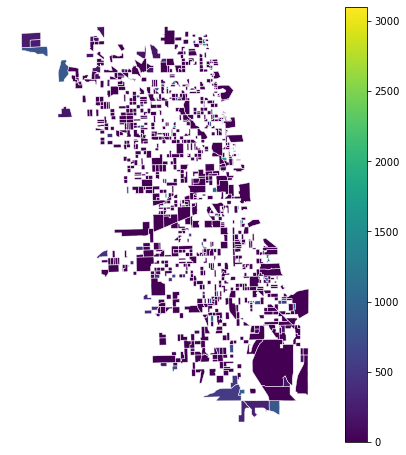

In [17]:
# map the absolute percent err
# Create the figure/axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot
test_set.plot(
    ax=ax, 
    column="APE", 
    edgecolor="white", 
    linewidth=0.5, 
    legend=True, 
    cmap="viridis"
)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

## Prediction - Philadelphia

In [18]:
philly_data = gpd.read_file('data/philly_data.geojson').set_crs("epsg:3857", allow_override=True,)
philly_data_filter = pd.read_csv('data/philly_data_filter.csv')

In [19]:
philly_data_filter

,GEOID,total_pop,median_rent,median_income,median_age,pct_college_degree,pct_racial_minorities,pct_property_owner,pct_commuter_PuT,DistRes,DistOffice,dist_to_cbd
0,421010090004,1970.0,1187.0,69671.596558,19.6,0.551724,0.285279,0.028881,0.293103,218.506743,1962.775024,2857.122555
1,421010188002,1290.0,1143.0,47926.000000,27.9,0.060719,0.719380,0.686813,0.084034,4387.035207,7775.447155,9303.483359
2,421010382002,1029.0,1100.0,48636.000000,39.0,0.171348,0.081633,0.486804,0.137255,3729.283551,7401.675139,8264.259537
3,421010090001,455.0,983.0,106094.000000,25.3,0.848485,0.162637,0.245455,0.412371,495.506816,2342.482803,3083.761064
4,421010090002,2273.0,1288.0,69671.596558,19.3,0.562500,0.371755,0.042373,0.261538,204.986683,2121.170161,2934.934663
...,...,...,...,...,...,...,...,...,...,...,...,...
1331,421010008034,376.0,1350.0,250001.000000,70.3,0.718663,0.026596,0.754545,0.181818,836.608856,819.237259,1012.403568
1332,421010007001,931.0,1796.0,69671.596558,46.8,0.502703,0.215897,0.448000,0.425094,921.243135,708.219369,1045.740830
1333,421010309001,1570.0,1167.0,50982.000000,34.4,0.077465,0.589172,0.535985,0.045153,5184.306643,11147.801904,15892.369413
1334,421010318001,1370.0,987.0,45875.000000,37.4,0.243151,0.624818,0.792608,0.109873,6087.841502,10933.384526,14778.584496


In [20]:
philly_data_filter = philly_data_filter.drop(columns = ["GEOID"])

In [21]:
# get the prediction from the best random forest model
philly_predictions = grid.best_estimator_.predict(philly_data_filter)

In [22]:
# add the prediction result to the philly df
# boardings should be integers
philly_data['predictions'] = philly_predictions.round(0)

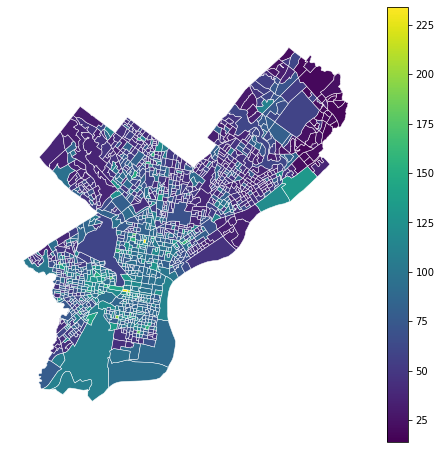

In [23]:
# map the absolute percent err
# Create the figure/axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot
philly_data.plot(
    ax=ax, 
    column="predictions", 
    edgecolor="white", 
    linewidth=0.5, 
    legend=True, 
    cmap="viridis"
)

# Format
ax.set_axis_off()
ax.set_aspect("equal")